In [5]:
import pyreadr

In [6]:
import requests

url = "https://raw.githubusercontent.com/shokru/mlfactor.github.io/master/material/data_ml.RData"

with open("data_ml.RData", "wb") as f:
    f.write(requests.get(url).content)

In [8]:
result = pyreadr.read_r("data_ml.RData")
data_raw = result['data_ml']

data_raw['date'] = pd.to_datetime(data_raw['date'])

data_ml = data_raw.loc[
    (data_raw['date'] > '1999-12-31') &
    (data_raw['date'] < '2019-01-01')
]

In [11]:
data_ml = (
    data_raw
    .loc[
        (data_raw['date'] > '1999-12-31') &
        (data_raw['date'] < '2019-01-01')
    ]
    .sort_values(['date', 'stock_id'])
    .reset_index(drop=True)
)


In [12]:
data_ml.iloc[0:6, 0:6]

,stock_id,date,Advt_12M_Usd,Advt_3M_Usd,Advt_6M_Usd,Asset_Turnover
0,1,2000-01-31,0.41,0.39,0.42,0.19
1,2,2000-01-31,0.70,0.74,0.72,0.55
2,3,2000-01-31,0.15,0.12,0.15,0.02
3,4,2000-01-31,0.37,0.32,0.35,0.29
4,5,2000-01-31,0.80,0.81,0.78,0.58
5,6,2000-01-31,0.78,0.76,0.76,0.22


Text(0, 0.5, 'count')

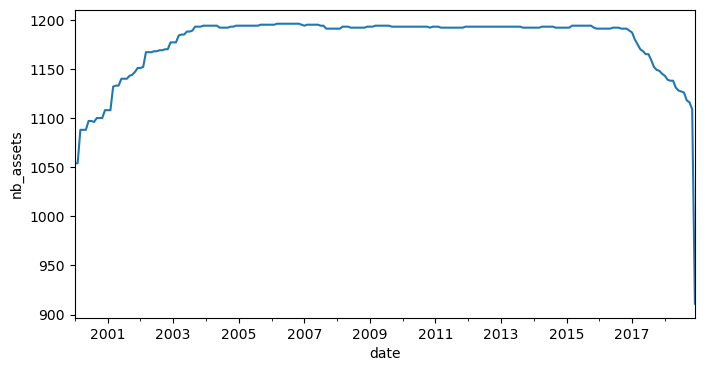

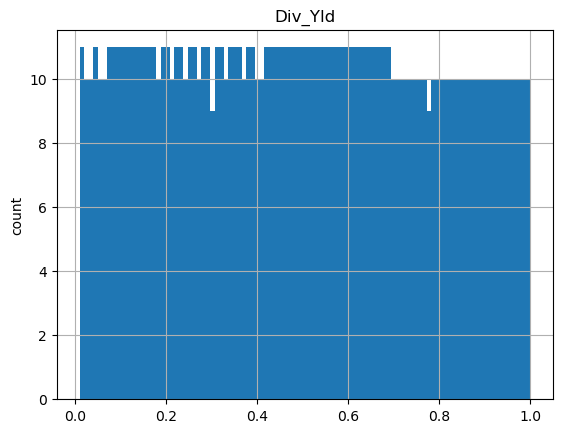

In [14]:
import matplotlib.pyplot as plt
pd.Series(data_ml.groupby('date').size()).plot(figsize=(8,4)) # counting the number of assets for each date
plt.ylabel('nb_assets')    

features=list(data_ml.iloc[:,3:95].columns) # Keep the feature's column names (hard-coded, beware!)
features_short =["Div_Yld", "Eps", "Mkt_Cap_12M_Usd", "Mom_11M_Usd", 
                    "Ocf", "Pb", "Vol1Y_Usd"]

col_feat_Div_Yld=data_ml.columns.get_loc('Div_Yld') # finding the location of the column/feature Div_Yld
is_custom_date =data_ml['date']=='2000-02-29'       # creating a boolean index to filter on 
data_ml[is_custom_date].iloc[:,[col_feat_Div_Yld]].hist(bins=100) # using the hist 
plt.ylabel('count')

In [15]:
df_median=[]          #creating empty placeholder for temporary dataframe
df=[]                #creating empty placeholder for temporary dataframe
import numpy as np
df_median=data_ml[['date','R1M_Usd','R12M_Usd']].groupby(['date']).median() # computings medians for both labels at each date 
df_median.rename(columns={"R1M_Usd": "R1M_Usd_median", "R12M_Usd": "R12M_Usd_median"},inplace=True)
df = pd.merge(data_ml,df_median,how='left', on=['date'])             # join the dataframes
data_ml['R1M_Usd_C'] = np.where(df['R1M_Usd'] > df['R1M_Usd_median'], 1.0, 0.0) # Create the categorical labels
data_ml['R12M_Usd_C'] = np.where(df['R12M_Usd'] > df['R12M_Usd_median'], 1.0, 0.0) # Create the categorical labels
df_median=[]          #removing the temp dataframe to keep it light!
df=[]                 #removing the temp dataframe to keep it light!

In [16]:
separation_date = "2014-01-15"
idx_train=data_ml.index[(data_ml['date'] < separation_date)].tolist() 
idx_test=data_ml.index[(data_ml['date'] >= separation_date)].tolist() 

In [18]:
stock_ids_short=[]   # creating empty placeholder for temporary dataframe
stock_days=[]        # creating empty placeholder for temporary dataframe
stock_ids=data_ml['stock_id'].unique() # A list of all stock_ids
stock_days=data_ml[['date','stock_id']].groupby(['stock_id']).count().reset_index() # compute the number of data points per stock
stock_ids_short=stock_days.loc[stock_days['date'] == (stock_days['date'].max())] # Stocks with full data
stock_ids_short=stock_ids_short['stock_id'].unique() ### in order to get a list 
is_stock_ids_short=data_ml['stock_id'].isin(stock_ids_short)  
returns=data_ml[is_stock_ids_short].pivot(index='date',columns='stock_id',values='R1M_Usd') # compute returns in matrix format